In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
def bs_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0.0)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


In [3]:
def implied_vol_call(price, S, K, T, r):
    if price <= 0 or T <= 0:
        return np.nan

    intrinsic = max(S - K, 0.0)
    if price < intrinsic:
        return np.nan

    try:
        return brentq(
            lambda sigma: bs_call_price(S, K, T, r, sigma) - price,
            1e-6, 5.0, maxiter=500
        )
    except:
        return np.nan


In [4]:
SPOT = 25694
RISK_FREE_RATE = 0.0675  # 6.75% continuous


In [15]:
from datetime import datetime

valuation_date = datetime(2026, 1, 17)

expiry_dates = {
    "2026-01-20": datetime(2026, 1, 20),
    "2026-01-27": datetime(2026, 1, 27),
    "2026-02-03": datetime(2026, 2, 3),
    "2026-02-10": datetime(2026, 2, 10),
}


def time_to_maturity(expiry):
    return (expiry - valuation_date).days / 365.0


In [6]:
data_20jan = pd.DataFrame({
    "strike": [
        24900,24950,25000,25050,25100,25150,25200,25250,25300,25350,
        25400,25450,25500,25550,25600,25650,25700,25750,25800,25850,
        25900,25950,26000,26050,26100,26150,26200,26250,26300,26350,
        26400,26450,26500
    ],
    "ltp": [
        825.50,761.95,720.70,672.55,622.60,574.10,523.85,477.55,
        428.35,380.00,333.80,290.95,246.95,207.30,171.00,138.00,
        108.45,84.00,64.10,47.95,35.30,25.15,18.20,12.75,8.85,
        6.60,5.15,4.05,3.35,2.85,2.40,2.05,1.85
    ]
})


In [7]:
data_27jan = pd.DataFrame({
    "strike": [
        24900,24950,25000,25050,25100,25150,25200,25250,25300,25350,
        25400,25450,25500,25550,25600,25650,25700,25750,25800,25850,
        25900,25950,26000,26050,26100,26150,26200,26250,26300,26350,
        26400,26450,26500
    ],
    "ltp": [
        873.00,824.10,765.00,725.80,676.15,626.05,585.55,525.10,
        491.70,453.60,408.00,369.05,332.00,292.55,258.25,225.35,
        199.25,172.10,146.70,124.05,104.50,87.95,72.00,60.00,
        48.85,40.90,33.70,28.75,23.95,20.20,17.20,14.85,12.95
    ]
})


In [8]:
data_03feb = pd.DataFrame({
    "strike": [
        24900,24950,25000,25050,25100,25150,25200,25250,25300,25350,
        25400,25450,25500,25550,25600,25650,25700,25750,25800,25850,
        25900,25950,26000,26050,26100,26150,26200,26250,26300,26350,
        26400,26450,26500
    ],
    "ltp": [
        945.05,899.70,849.25,811.35,766.65,725.55,674.85,644.90,
        596.20,567.50,524.60,488.55,446.70,424.10,383.15,355.95,
        323.00,297.00,272.45,245.00,223.00,198.55,182.30,163.00,
        144.55,130.10,115.20,102.40,91.45,79.00,69.45,60.35,53.30
    ]
})


In [14]:
data_10feb = pd.DataFrame({
    "strike": [
        24900,24950,25000,25050,25100,25150,25200,25250,25300,25350,
        25400,25450,25500,25550,25600,25650,25700,25750,25800,25850,
        25900,25950,26000,26050,26100,26150,26200,26250,26300,26350,
        26400,26450,26500
    ],
    "ltp": [
        993.85,950.25,916.75,862.05,820.95,783.25,742.90,703.25,
        661.00,626.75,584.05,554.70,513.00,486.25,440.00,424.45,
        387.60,355.00,329.65,307.80,281.05,265.20,234.00,223.85,
        194.75,180.40,161.60,145.60,132.25,116.00,104.30,94.20,
        83.30
    ]
})


In [20]:
def compute_iv_surface(df, expiry_key):
    T = time_to_maturity(expiry_dates[expiry_key])

    ivs = []
    for _, row in df.iterrows():
        iv = implied_vol_call(
            row["ltp"], SPOT, row["strike"], T, RISK_FREE_RATE
        )
        ivs.append(iv)

    return pd.DataFrame({
        "strike": df["strike"].values,
        "expiry": pd.to_datetime(expiry_dates[expiry_key]),
        "T": T,
        "iv": ivs
    }).dropna()



In [21]:
surface_df = pd.concat([
    compute_iv_surface(data_20jan, "2026-01-20"),
    compute_iv_surface(data_27jan, "2026-01-27"),
    compute_iv_surface(data_03feb, "2026-02-03"),
    compute_iv_surface(data_10feb, "2026-02-10"),
])


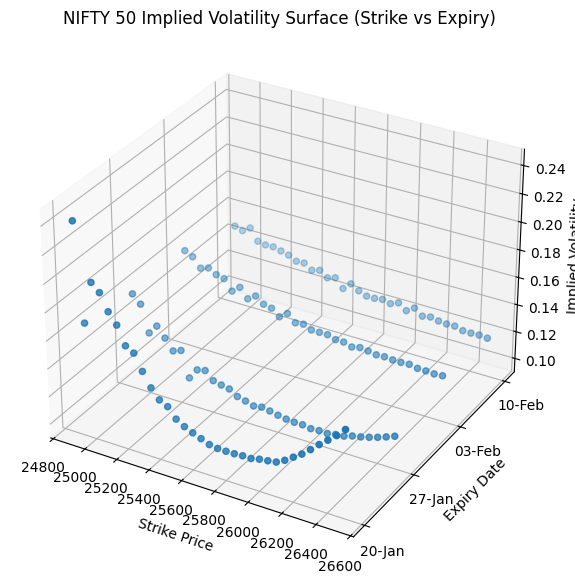

In [22]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

expiry_numeric = surface_df["expiry"].map(datetime.toordinal)

ax.scatter(
    surface_df["strike"],
    expiry_numeric,
    surface_df["iv"],
    s=20
)

ax.set_xlabel("Strike Price")
ax.set_ylabel("Expiry Date")
ax.set_zlabel("Implied Volatility")

ax.set_yticks(expiry_numeric.unique())
ax.set_yticklabels(
    surface_df["expiry"].dt.strftime("%d-%b").unique()
)

plt.title("NIFTY 50 Implied Volatility Surface (Strike vs Expiry)")
plt.show()


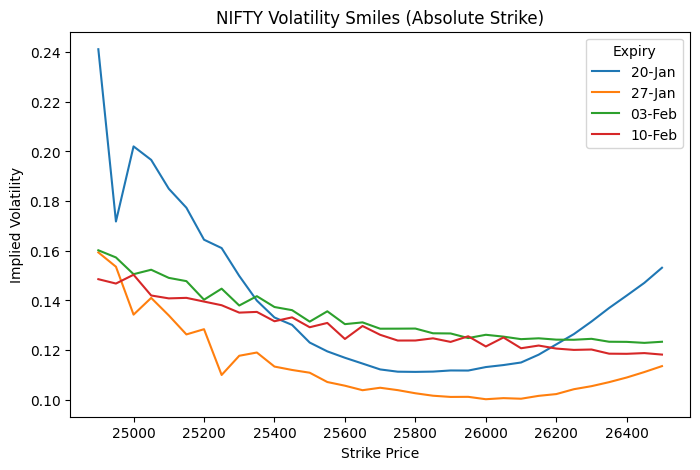

In [23]:
plt.figure(figsize=(8,5))

for exp in surface_df["expiry"].unique():
    subset = surface_df[surface_df["expiry"] == exp]
    plt.plot(
        subset["strike"],
        subset["iv"],
        label=exp.strftime("%d-%b")
    )

plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend(title="Expiry")
plt.title("NIFTY Volatility Smiles (Absolute Strike)")
plt.show()
